In [1]:
import pygplates
from gprm import PointDistributionOnSphere
from gprm.datasets import Reconstructions
import pygmt
import numpy as np
import geopandas as gpd
#from shapely.geometry import LineString, Polygon, Point
from gprm.utils.deformation import geodataframe_topological_reconstruction

%load_ext autoreload
%autoreload 2


In [2]:
M2019 = Reconstructions.fetch_Muller2019()


In [3]:
topological_model = pygplates.TopologicalModel(
            M2019.dynamic_polygons,
            M2019.rotation_model,
            # Enable strain rate clamping to better control crustal stretching factors...
            default_resolve_topology_parameters=pygplates.ResolveTopologyParameters(enable_strain_rate_clamping=True))


In [4]:
#features = pygplates.FeatureCollection('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')
#gdf = gpd.read_file('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')



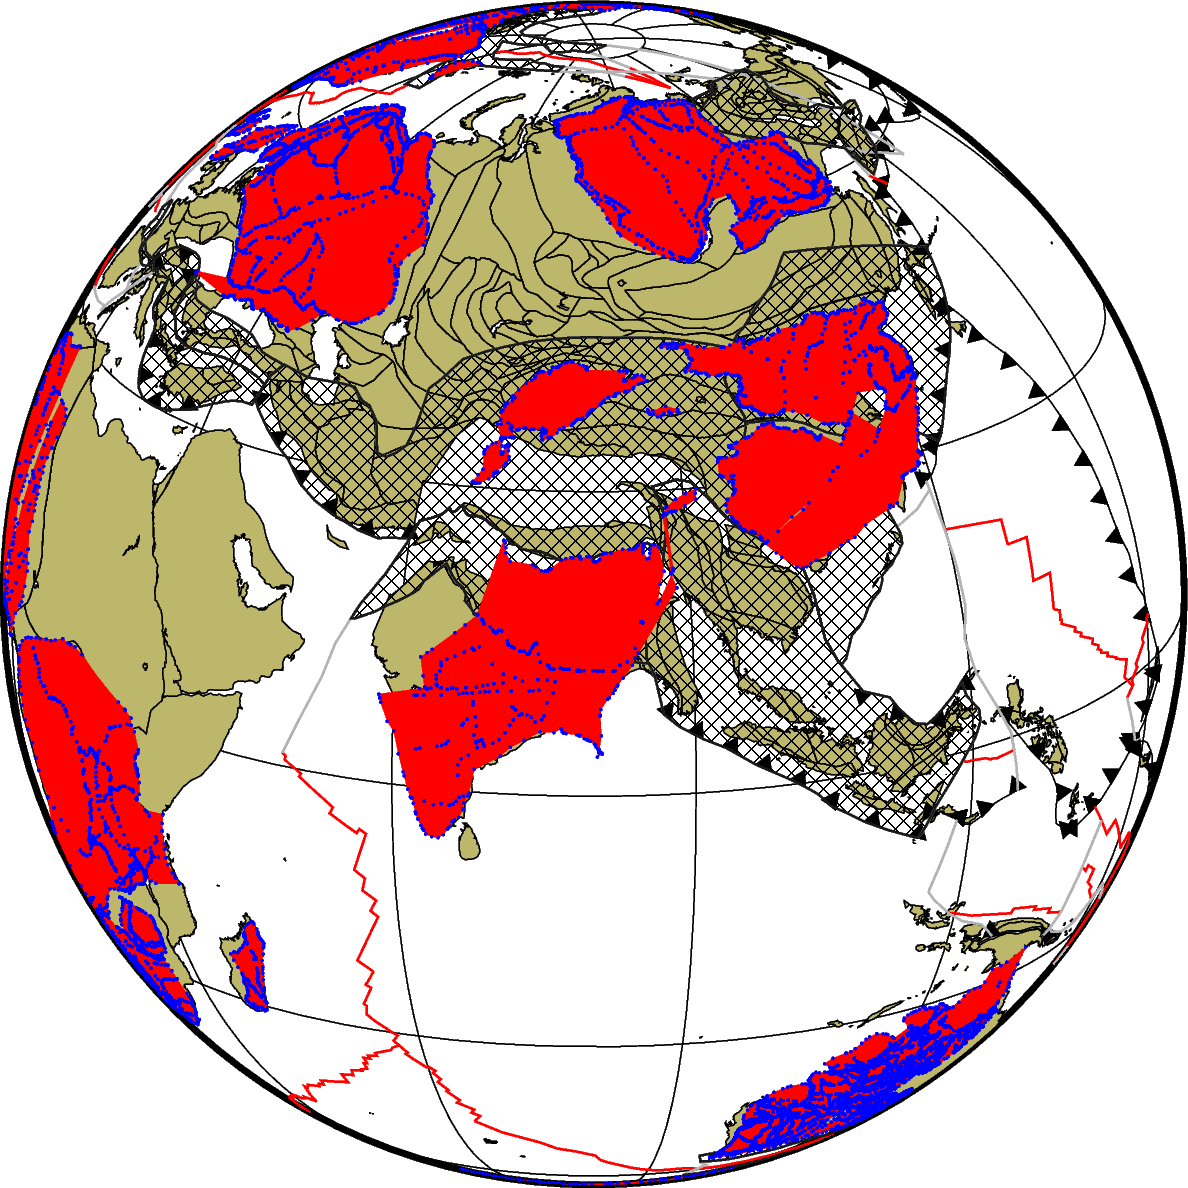

In [7]:
#gdf = gpd.read_file('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

gdf = gpd.read_file('/Users/simon/GIT/gpdata/reconstructions/PEHRSSON2015/PlatePolygons.shp')

reconstruction_time = 35.

result = geodataframe_topological_reconstruction(gdf, topological_model, reconstruction_time,
                                                 deactivate_points_that_fall_outside_a_network=None)

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G80/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

#fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
#fig.plot(x=result.geometry.x, y=result.geometry.y, style='c0.1c', color='red')

result.to_file('tmp.gmt', driver='OGR_GMT')
fig.plot(data='tmp.gmt', color='red')
fig.plot(data='tmp.gmt', style='c0.025c', color='blue')

fig.show(width=800)


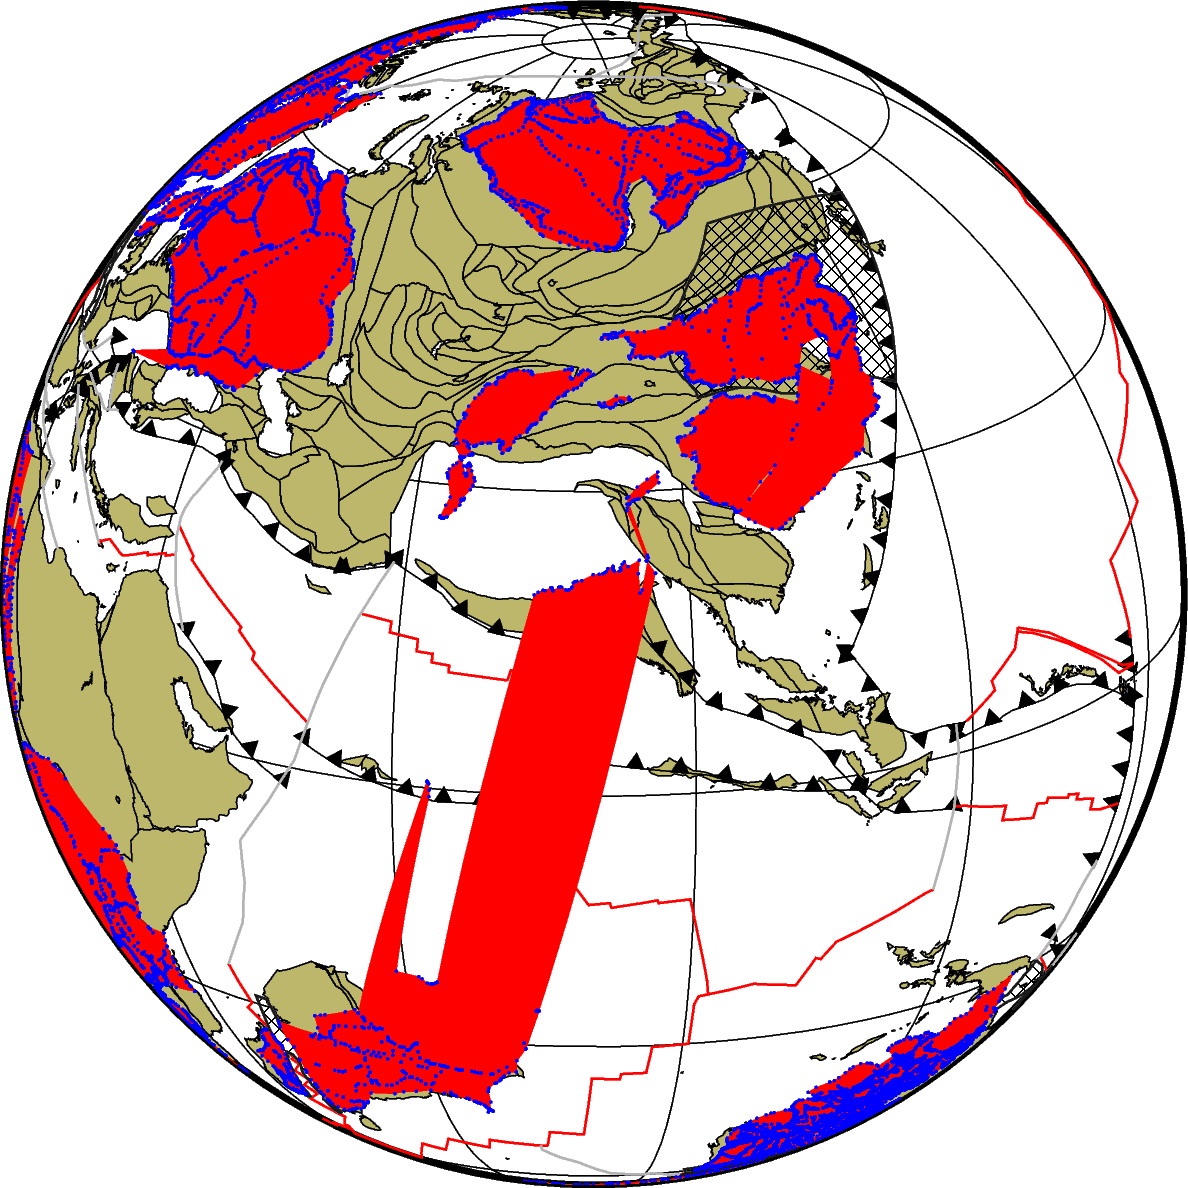

In [14]:
#gdf = gpd.read_file('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

gdf = gpd.read_file('/Users/simon/GIT/gpdata/reconstructions/PEHRSSON2015/PlatePolygons.shp')

reconstruction_time = 85.

result = deform_geometries(gdf, topological_model, reconstruction_time,
                           deactivate_points_that_fall_outside_a_network=None)

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G80/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

#fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
#fig.plot(x=result.geometry.x, y=result.geometry.y, style='c0.1c', color='red')

result.to_file('tmp.gmt', driver='OGR_GMT')
fig.plot(data='tmp.gmt', color='red')
fig.plot(data='tmp.gmt', style='c0.025c', color='blue')

fig.show(width=800)


1843239 1843239


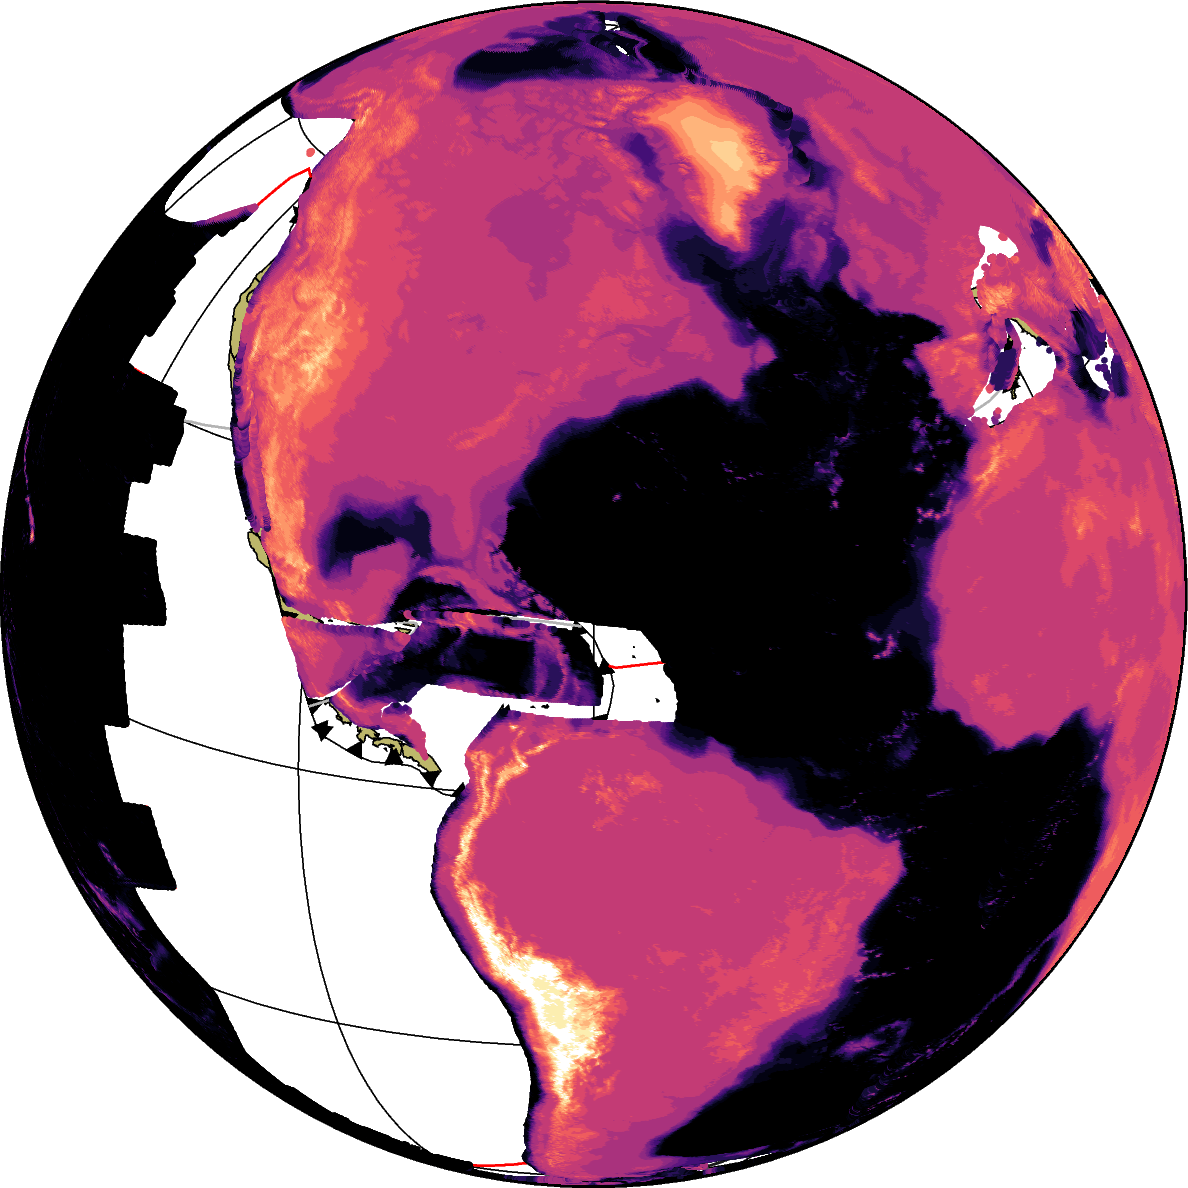

In [53]:
from gprm import GPlatesRaster
from gprm.utils.deformation import topological_reconstruction

topo = GPlatesRaster('/Users/simon/Data/GMTdata/hawaii2017/earth_relief_10m.grd')

XX,YY = np.meshgrid(topo.gridX,topo.gridY)

geometry_points = [(lat,lon) for lat,lon in zip(YY.flatten(),XX.flatten())]


reconstruction_time = 40.

pts, valid_index = topological_reconstruction(topological_model, geometry_points, reconstruction_time,
                                              return_inactive_points=True, deactivate_points=False)

print(len(pts[0]), len(topo.gridZ.flatten()[valid_index]))

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)


fig = pygmt.Figure()
fig.basemap(region='d', projection='G-60/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

#fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
pygmt.makecpt(cmap='magma', series=[-6000,4000,500])
fig.plot(x=pts[1], y=pts[0], style='c0.05c', color=topo.gridZ.flatten()[valid_index], cmap=True)

fig.show(width=800)